In [1]:
import sys, os, gzip, shutil
import datetime as dt
import pandas as pd
import geopandas as gpd
import numpy as np
import holidays
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_columns', None)
import warnings
warnings.filterwarnings("ignore")

# Arterials

In [13]:
import geopandas as gp
champ_dir = r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF\champ_hwy_shapefile'
champ = gp.read_file(os.path.join(champ_dir, 'freeflow.shp'))
champ.crs = 'EPSG:2227'
champ.head(2)

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,SPEED,DISTANCE,TIME,LANE_AM,LANE_OP,LANE_PM,BUSLANE_AM,BUSLANE_OP,BUSLANE_PM,TOLLAM_DA,TOLLAM_SR2,TOLLAM_SR3,TOLLPM_DA,TOLLPM_SR2,TOLLPM_SR3,TOLLEA_DA,TOLLEA_SR2,TOLLEA_SR3,TOLLMD_DA,TOLLMD_SR2,TOLLMD_SR3,TOLLEV_DA,TOLLEV_SR2,TOLLEV_SR3,VALUETOLL_,PASSTHRU,BUSTPS_AM,BUSTPS_OP,BUSTPS_PM,TSVA,TSIN,BIKE_CLASS,PER_RISE,ONEWAY,PROJ,DTA_EDIT_F,TOLLTIME,PHASE,A_B,ACTION,AB,GisLen,geometry
0,1,20368,0,1,2000,3,6,None,None,SF,10,0.01410,0.08460,7,7,7,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,107.83,T,0,0.0,0,None,0,0.0,0,None,None,1 20368,74.14878,"LINESTRING (6008120.30634 2086464.60113, 60081..."
1,1,20373,0,1,2000,3,6,None,None,SF,10,0.07441,0.44646,7,7,7,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,107.83,T,0,0.0,0,None,0,0.0,0,None,None,1 20373,390.58781,"LINESTRING (6008120.30634 2086464.60113, 60079..."


In [37]:
#Define NAD 1983 StatePlane California III
cal3 = {'proj': 'lcc +lat_1=37.06666666666667 +lat_2=38.43333333333333 +lat_0=36.5 +lon_0=-120.5 +x_0=2000000 +y_0=500000.0000000002', 'ellps': 'GRS80', 'datum': 'NAD83', 'no_defs': True}

In [41]:
champ = champ.to_crs(cal3)

In [3]:
adt_sta = pd.read_excel(os.path.join(r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF', 'CMP_ADT_Counts.xlsx'), sheet_name='Count_locations')
adt_sta.head(1)

,Sno.,ID_Dir,ID,StationID,2015 Name,Direction,CHAMP_link,AT,FT
0,1,1_NB,1_,1,1_01_19thSt_MoragaSt.NoriegaSt,NB,27335 27341,3,7


In [5]:
champ_with_adt_stations = champ[['AB', 'A', 'B', 'geometry']].merge(adt_sta[['StationID', 'ID_Dir', 'CHAMP_link']], left_on='AB', right_on='CHAMP_link')
len(champ_with_adt_stations)

42

In [43]:
champ.to_file(os.path.join(champ_dir, 'champ_prj.shp'))

In [69]:
champ_with_adt_stations.to_file(os.path.join(r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF', 'champ_prj_with_adt_stations.shp'))

In [4]:
champ_with_adt_stations = pd.read_csv(os.path.join(r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF', 'adt_stations_champ_inrix_xdsegs.csv'))
champ_with_adt_stations.head(2)

,FID,AB,A,B,StationID,ID_Dir,CHAMP_link,XDSegID,Note
0,0,20455 20472,20455,20472,3,3_SB,20455 20472,449841027,NaN
1,1,20472 20455,20472,20455,3,3_NB,20472 20455,449830764,NaN


In [5]:
PEMSDIR = r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\PeMS'
OUTDIR = PEMSDIR
data_type = 'station_meta'
district = 4
ca_holidays = holidays.UnitedStates(state='CA')

In [138]:
adt_cnts = pd.read_excel(os.path.join(r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF', 'CMP_ADT_Counts.xlsx'), sheet_name='15min_data')
adt_cnts.head(1)

,ID,Direction,Year,Date,Time,Vol,TP,ID_Dir,AT,FT
0,1_,NB,2015,2015.05.01,0000-0015,128,4_EV,1_NB,27335 27341,3


In [139]:
adt_cnts['rDate']=pd.to_datetime(adt_cnts['Date'])

In [140]:
epochs = pd.read_excel(os.path.join(r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF', 'CMP_ADT_Counts.xlsx'), sheet_name='Timep_map')
epochs.insert(0, 'Epoch', range(0, len(epochs)))
epochs.head(2)

,Epoch,Time_interval,Time_period
0,0,0000-0015,4_EV
1,1,0015-0030,4_EV


In [141]:
adt_cnts = pd.merge(adt_cnts, epochs, left_on='Time', right_on='Time_interval', how='left')

In [142]:
adt_cnts = pd.merge(adt_cnts, champ_with_adt_stations[['CHAMP_link', 'XDSegID']], left_on='AT', right_on='CHAMP_link', how='left')

In [144]:
adt_cols = ['ID', 'Direction', 'Year', 'Date', 'Time', 'Vol', 'TP', 'ID_Dir', 
            'rDate', 'Epoch', 'Time_interval', 'Time_period', 'CHAMP_link', 'XDSegID']
champ_cols = ['AB', 'USE', 'CAP', 'AT', 'FT', 'SPEED', 'DISTANCE', 'TIME', 'LANE_AM', 'LANE_OP', 'LANE_PM']
adt_cnts = adt_cnts[adt_cols].merge(champ[champ_cols],  left_on='CHAMP_link', right_on= 'AB', how='left')

In [82]:
SPEED_DIR = r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF\INRIX_Speeds'
INPUT_PATHS = [['vdf_segments_2021-05-04_to_2021-05-10_1_min_part_', 1]]
df_speed = pd.read_csv(os.path.join(SPEED_DIR, '%s%s\data.csv' %(p[0],p[1])))
df_speed.rename(columns={'Segment ID':'XDSegID', 'Speed(miles/hour)':'Speed'}, inplace=True)

In [85]:
df_speed['Date_Time'] = df_speed['Date Time'].str[:19]
df_speed['Date_Time'] = df_speed['Date_Time'].str.replace('T', " ")
df_speed['Date'] = df_speed['Date_Time'].str[:10]
df_speed['rDate']=pd.to_datetime(df_speed['Date'])
df_speed['Hour']= df_speed['Date_Time'].str[11:13]
df_speed['Minute']= df_speed['Date_Time'].str[14:16]
df_speed['Epoch']= df_speed['Hour'].astype(int) * 4 + df_speed['Minute'].astype(int)//15  # convert each minute to 15-min epoch

In [150]:
grpby_cols = ['XDSegID', 'rDate', 'Epoch']
df_speed_15min = df_speed.groupby(grpby_cols).agg({'Speed':['mean', 'count']}).reset_index()
df_speed_15min.columns = grpby_cols + ['AvgSpeed', 'Numof1Minutes']

In [152]:
adt_cnts_speeds = pd.merge(adt_cnts, df_speed_15min, on=['XDSegID', 'rDate', 'Epoch'], how='left')

In [156]:
adt_cnts_speeds['flow'] = adt_cnts_speeds['Vol'] * 4 
adt_cnts_speeds['density'] = adt_cnts_speeds['flow'] / adt_cnts_speeds['AvgSpeed']
adt_cnts_speeds['lane_flow'] = np.where(adt_cnts_speeds['Time_period']=='1_AM',
                                        adt_cnts_speeds['flow'] / adt_cnts_speeds['LANE_AM'],
                                        np.where(adt_cnts_speeds['Time_period']=='3_PM',
                                                adt_cnts_speeds['flow'] / adt_cnts_speeds['LANE_PM'],
                                                adt_cnts_speeds['flow'] / adt_cnts_speeds['LANE_OP']))
adt_cnts_speeds['lane_density'] = adt_cnts_speeds['lane_flow'] / adt_cnts_speeds['AvgSpeed']

In [157]:
adt_cnts_speeds_notnan = adt_cnts_speeds[pd.notnull(adt_cnts_speeds['AvgSpeed'])]

In [158]:
adt_cnts_speeds_notnan.to_csv(os.path.join(r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\VDF', 'cmp_adt_counts_inrix_speeds.csv'))

## Overall Plots 

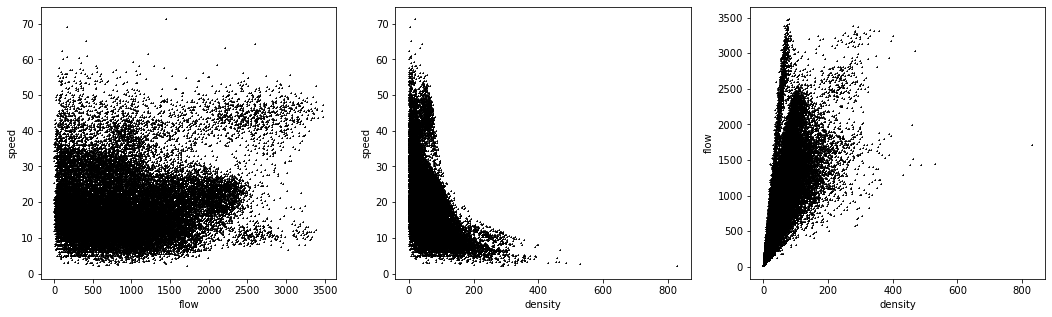

In [159]:
flow_scatter(adt_cnts_speeds_notnan, col_flow ='flow', col_speed= 'AvgSpeed', col_density = 'density')

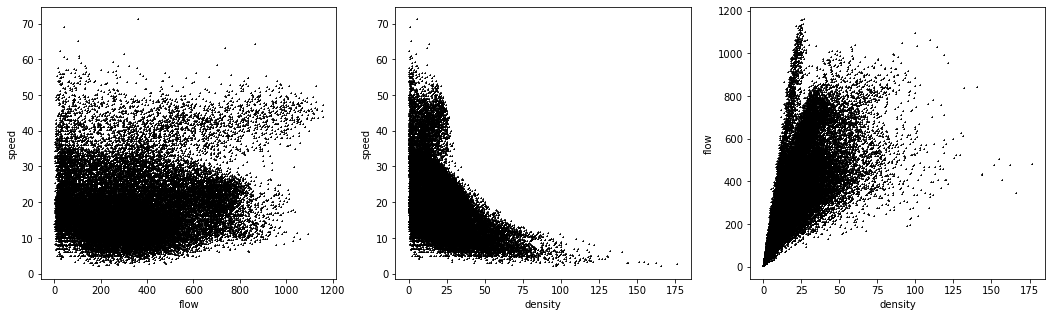

In [160]:
flow_scatter(adt_cnts_speeds_notnan, col_flow ='lane_flow', col_speed= 'AvgSpeed', col_density = 'lane_density')

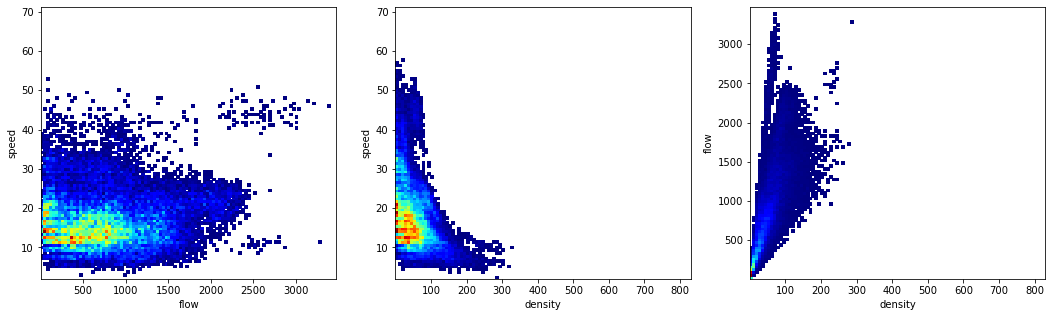

In [161]:
df, col_flow, col_speed, col_density = adt_cnts_speeds_notnan, 'flow', 'AvgSpeed', 'density'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.hist2d(df[col_flow], df[col_speed], (100, 100), cmin=3, cmap=plt.cm.jet)
ax1.set_xlabel('flow')
ax1.set_ylabel('speed')

ax2.hist2d(df[col_density], df[col_speed], (100, 100), cmin=3, cmap=plt.cm.jet)
ax2.set_xlabel('density')
ax2.set_ylabel('speed')

ax3.hist2d(df[col_density], df[col_flow], (100, 100), cmin=3, cmap=plt.cm.jet)
ax3.set_xlabel('density')
ax3.set_ylabel('flow')
plt.show()

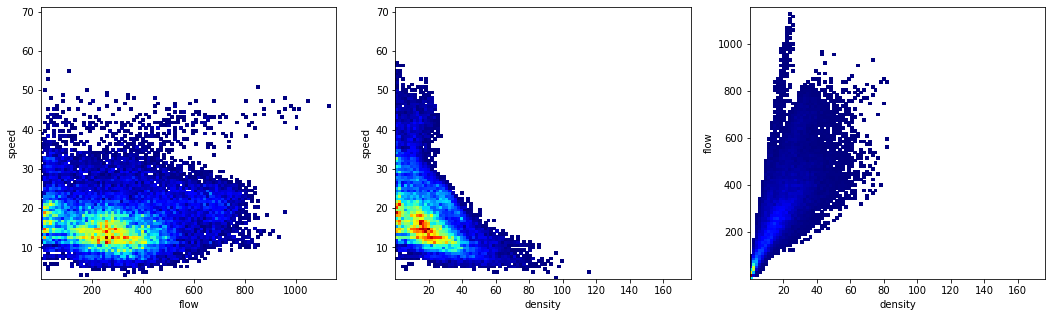

In [162]:
df, col_flow, col_speed, col_density = adt_cnts_speeds_notnan, 'lane_flow', 'AvgSpeed', 'lane_density'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.hist2d(df[col_flow], df[col_speed], (100, 100), cmin=3, cmap=plt.cm.jet)
ax1.set_xlabel('flow')
ax1.set_ylabel('speed')

ax2.hist2d(df[col_density], df[col_speed], (100, 100), cmin=3, cmap=plt.cm.jet)
ax2.set_xlabel('density')
ax2.set_ylabel('speed')

ax3.hist2d(df[col_density], df[col_flow], (100, 100), cmin=3, cmap=plt.cm.jet)
ax3.set_xlabel('density')
ax3.set_ylabel('flow')
plt.show()

## By Groups 

In [179]:
adt_cnts_speeds_notnan['traveltime'] = 60* adt_cnts_speeds_notnan['DISTANCE']/adt_cnts_speeds_notnan['AvgSpeed']
adt_cnts_speeds_notnan['vcratio'] = adt_cnts_speeds_notnan['lane_flow']/adt_cnts_speeds_notnan['CAP']

In [211]:
adt_cnts_speeds_notnan.drop_duplicates(['AT', 'FT', 'ID_Dir']).groupby(['AT', 'FT']).ID_Dir.count()

AT  FT
0   7     10
    12     4
    15     2
1   7      8
    12     2
    15     4
2   3      2
    7      2
3   3      1
    7      7
Name: ID_Dir, dtype: int64

In [212]:
adt_cnts_speeds_notnan.drop_duplicates(['AT', 'FT', 'ID_Dir']).groupby(['FT']).ID_Dir.count()

FT
3      3
7     27
12     6
15     6
Name: ID_Dir, dtype: int64

In [120]:
area_types = {0: 'Regional Core', 
              1: 'CBD', 
              2: 'Urban Business', 
              3: 'Urban',  
              4: 'Suburban', 
              5: 'Rural'}
facility_types = {1: 'Fwy-Fwy Connector', 2: 'Freeway', 3: 'Expressway', 4: 'Collector', 5: 'Ramp', 
                  6: 'Centroid Connector', 7: 'Major Arterial', 9: 'Alley', 10: 'Metered Ramp', 11: 'Local', 
                  12: 'Minor Arterial', 13: 'Bike-Only!', 15: 'Super Arterial'}

In [201]:
def modeled_speed(d):
    T0 = d['TIME']
    V = d['lane_flow']
    C = d['CAP']
    if d['FT'] == 3: #Expressway
        tt = T0*1.0*(1 + 0.71*(0.337*V/C)**2.1)/60 #minute to hour
    else:
        tt = T0*1.8*(1 + 0.60*(0.337*V/C)**3.5)/60 #minute to hour
    spd = d['DISTANCE']/tt
    return spd

In [202]:
adt_cnts_speeds_notnan['ModelSpeed'] = adt_cnts_speeds_notnan.apply(lambda x: modeled_speed(x), axis=1)
adt_cnts_speeds_notnan.head(1)

,ID,Direction,Year,Date,Time,Vol,TP,ID_Dir,rDate,Epoch,Time_interval,Time_period,CHAMP_link,XDSegID,AB,USE,CAP,AT,FT,SPEED,DISTANCE,TIME,LANE_AM,LANE_OP,LANE_PM,AvgSpeed,Numof1Minutes,flow,density,lane_flow,lane_density,ModelSpeed,traveltime,vcratio
0,1_,NB,2015,2015.05.01,0000-0015,128,4_EV,1_NB,2015-05-01,0,0000-0015,4_EV,27335 27341,1626704596,27335 27341,1,950,3,7,35,0.13,0.22286,3,3,3,28.933333,15.0,512,17.695853,170.666667,5.898618,19.443558,0.269585,0.179649


### By Area and Facility Types 

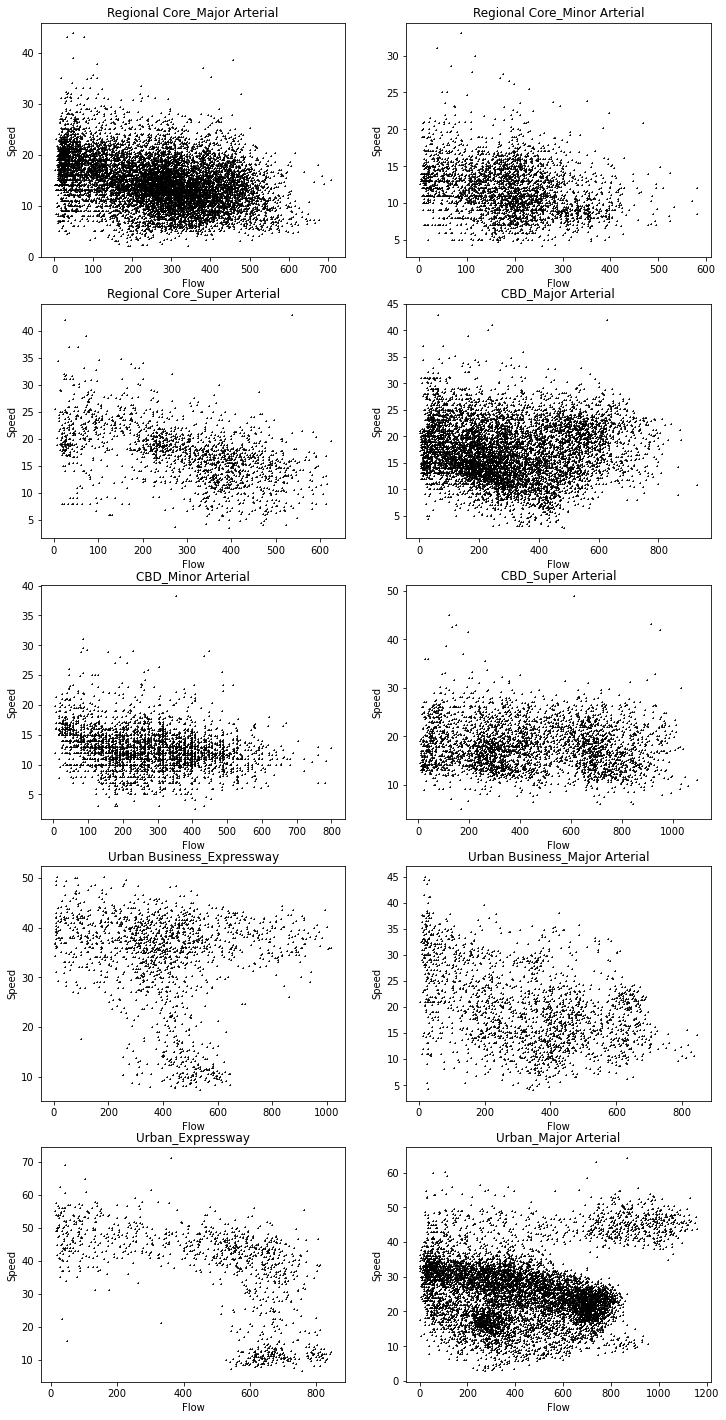

In [204]:
fig, ax = plt.subplots(5, 2, figsize=(12,25))
subid = 0
for at in area_types.keys():
    for ft in facility_types.keys():
        grp_speed = adt_cnts_speeds_notnan[(adt_cnts_speeds_notnan['AT']==at) & (adt_cnts_speeds_notnan['FT']==ft)]
        if len(grp_speed)>0:
            row, col = subid//2, subid%2
            ax[row, col].scatter(x = grp_speed['lane_flow'], y = grp_speed['AvgSpeed'], c='black', marker='+', s = 1)
            ax[row, col].set_xlabel('Flow')
            ax[row, col].set_ylabel('Speed')
            ax[row, col].set_title(area_types[at] + '_' + facility_types[ft])
            subid += 1

### Each station: Travel time vs VC ratio 

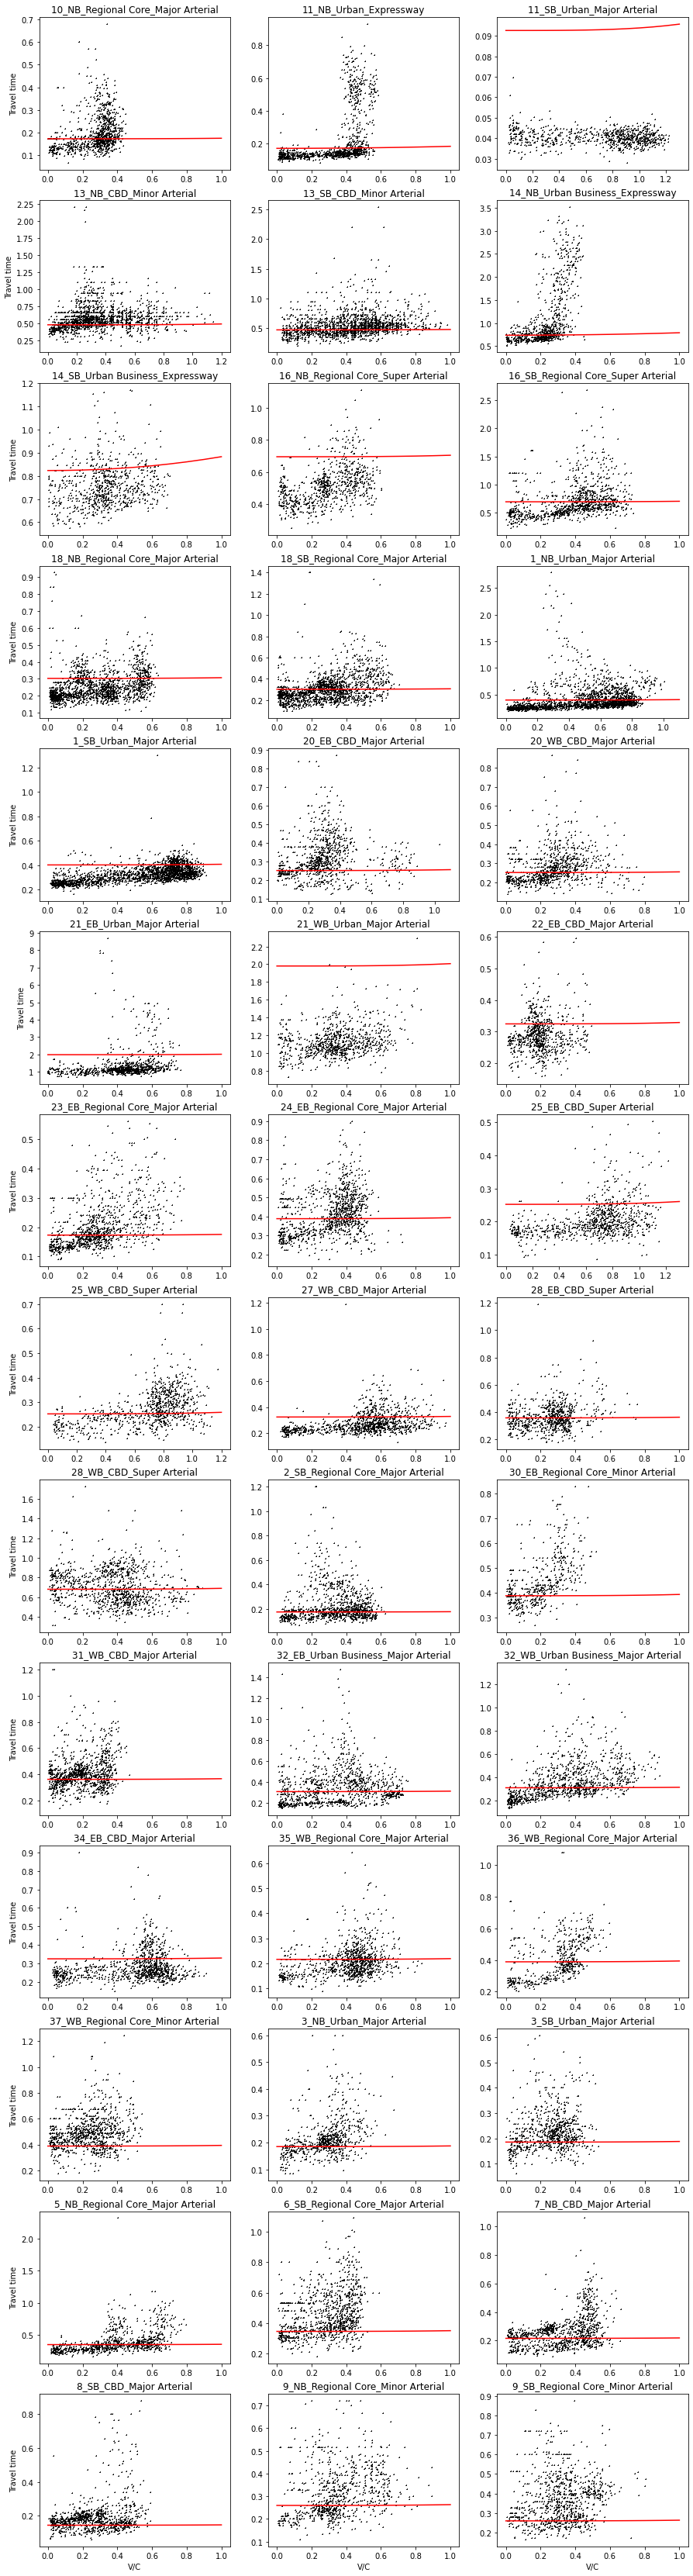

In [210]:
fig, ax = plt.subplots(14, 3, figsize=(15,60))
segs = adt_cnts_speeds_notnan.sort_values(by='ID_Dir').ID_Dir.unique().tolist()
subid = 0
for segdir in segs:
    df = adt_cnts_speeds_notnan[adt_cnts_speeds_notnan['ID_Dir']==segdir]
    atype = df.AT.unique()[0]
    ftype = df.FT.unique()[0]
    fftt = df.TIME.unique()[0]
    maxvc = df.vcratio.max()+0.1
    maxvc = max(maxvc, 1)
    vc_list = [v/10 for v in range(0,int((maxvc+0.1)*10))]
    if ftype == 3: #Expressway
        tt_list = [fftt*1.0*(1 + 0.71*(0.337*vc)**2.1) for vc in vc_list]
    else:
        tt_list = [fftt*1.8*(1 + 0.60*(0.337*vc)**3.5) for vc in vc_list]
    
    row, col = subid//3, subid%3
    ax[row, col].scatter(x = df['vcratio'], y = df['traveltime'], c='black', marker='+', s = 1)
    ax[row, col].plot(vc_list, tt_list, c='r')
    ax[row, col].set_title(segdir + '_' + area_types[atype] + '_' + facility_types[ftype])
    if subid%3==0:
        ax[row, col].set_ylabel('Travel time')
    if subid//3==13:
        ax[row, col].set_xlabel('V/C')
    subid += 1

### Each station: Speed vs Volume 

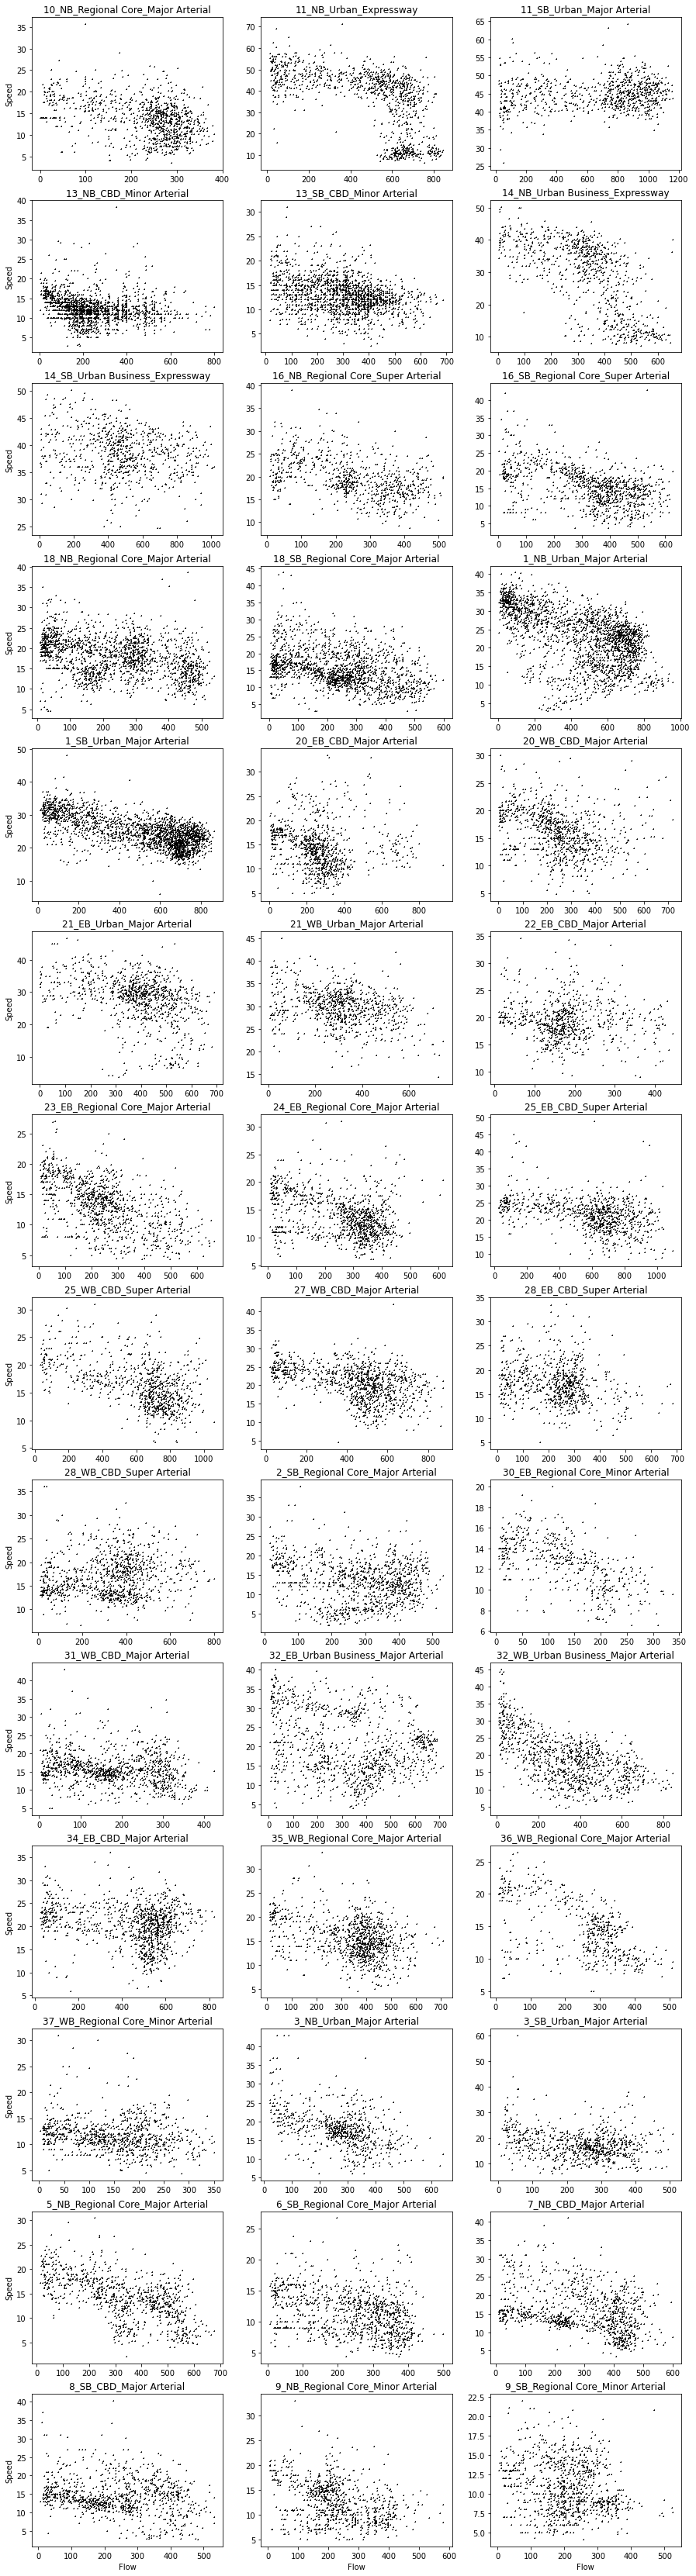

In [209]:
fig, ax = plt.subplots(14, 3, figsize=(15,60))
segs = adt_cnts_speeds_notnan.sort_values(by='ID_Dir').ID_Dir.unique().tolist()
subid = 0
for segdir in segs:
    df = adt_cnts_speeds_notnan[adt_cnts_speeds_notnan['ID_Dir']==segdir]
    atype = df.AT.unique()[0]
    ftype = df.FT.unique()[0]
    
    row, col = subid//3, subid%3
    ax[row, col].scatter(x = df['lane_flow'], y = df['AvgSpeed'], c='black', marker='+', s = 1)
    ax[row, col].set_title(segdir + '_' + area_types[atype] + '_' + facility_types[ftype])
    if subid%3==0:
        ax[row, col].set_ylabel('Speed')
    if subid//3==13:
        ax[row, col].set_xlabel('Flow')
    subid += 1

# Freeway PeMS

In [123]:
PEMSDIR = r'C:\Users\xzh263\Dropbox (KTC)\SFCTA CMP\2021 CMP\PeMS'
OUTDIR = PEMSDIR

monitor_loc = pd.read_csv(os.path.join(OUTDIR,'cmp_pems_monitoring_locations.csv'))
monitor_loc.head(2)

,station,location,direction
0,402814,Bay Bridge after TI,E
1,402815,Bay Bridge after TI,E


In [125]:
pems = pd.read_csv('S:/CMP/PeMS/SF_PeMS_Stations.csv')
pems = pems[pems['Type']=='Mainline']
pems.head(1)

,Fwy,District,County,City,CA PM,Abs PM,Length,ID,Name,Lanes,Type,Sensor Type,HOV,MS ID,IRM
0,I80-E,4.0,San Francisco,San Francisco,6.84,3.3,0.5,402815,NaN,5.0,Mainline,magnetometers,No,DSB02,N5-E-34-080-00684


In [126]:
sf_stations = pems['ID'].unique().tolist()

In [127]:
import dask.dataframe as dd
months = [4, 5]
sf_counts = pd.DataFrame()
colnames = ['Timestamp', 'Station', 'District', 'Freeway', 'Direction', 'Lane Type', 'Station Length',
           'Samples', 'Observed%', 'Total Flow', 'Avg Occupancy', 'Avg Speed', 
           'Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ', 'Lane 1 Avg Speed', 'Lane 1 Observed',
           'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed',
           'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed',
           'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed',
           'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed',
           'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed',
           'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed',
           'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed']
for month in months:
    if month ==4:
        for day in range(1, 31):
            if day<10:
                filename = 'S:/CMP/PeMS/d04_text_station_5min_2019_04_0' + str(day) + '.txt'
            else:
                filename = 'S:/CMP/PeMS/d04_text_station_5min_2019_04_' + str(day) + '.txt'
            df = dd.read_csv(filename, names = colnames, assume_missing=True)
            df_sf_day = df[df['Station'].isin(sf_stations)].compute()
            sf_counts = sf_counts.append(df_sf_day, ignore_index=True)
            
    if month ==5:
        for day in range(1, 32):
            if day<10:
                filename = 'S:/CMP/PeMS/d04_text_station_5min_2019_05_0' + str(day) + '.txt'
            else:
                filename = 'S:/CMP/PeMS/d04_text_station_5min_2019_05_' + str(day) + '.txt'
            df = dd.read_csv(filename, names = colnames, assume_missing=True)
            df_sf_day = df[df['Station'].isin(sf_stations)].compute()
            sf_counts = sf_counts.append(df_sf_day, ignore_index=True)

In [128]:
sf_counts = sf_counts[sf_counts['Observed%']>20]
len(sf_counts)

166095

In [129]:
sf_counts = sf_counts.merge(pems[['ID', 'Lanes']], left_on='Station', right_on='ID', how='left')
len(sf_counts[pd.isnull(sf_counts['Lanes'])])

0

In [130]:
sf_counts['flow'] = sf_counts['Total Flow'] * 12
sf_counts['density'] = sf_counts['flow'] / sf_counts['Avg Speed']

sf_counts['lane_flow'] = sf_counts['flow'] / sf_counts['Lanes']
sf_counts['lane_dens'] = sf_counts['lane_flow'] / sf_counts['Avg Speed']

## All lanes 

In [47]:
def flow_scatter(df, col_flow, col_speed, col_density):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    ax1.scatter(x = df[col_flow], y = df[col_speed], c='black', marker='+', s = 1)
    ax1.set_xlabel('flow')
    ax1.set_ylabel('speed')

    ax2.scatter(x = df[col_density], y = df[col_speed], c='black', marker='+', s = 1)
    ax2.set_xlabel('density')
    ax2.set_ylabel('speed')

    ax3.scatter(x = df[col_density], y = df[col_flow], c='black', marker='+', s = 1)
    ax3.set_xlabel('density')
    ax3.set_ylabel('flow')
    plt.show()

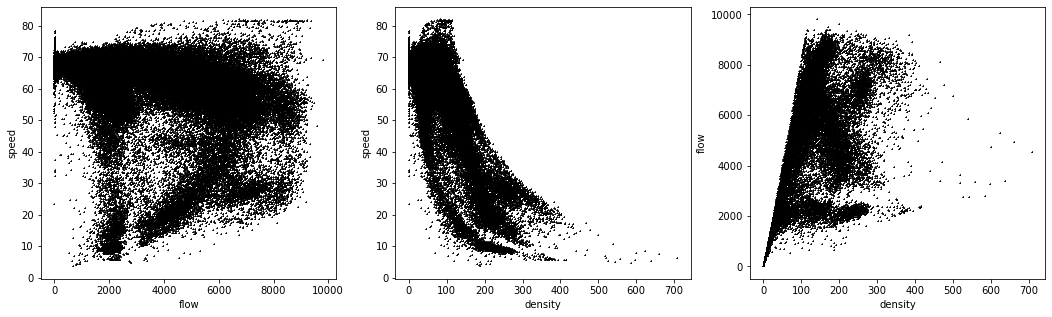

In [132]:
flow_scatter(sf_counts, col_flow ='flow', col_speed= 'Avg Speed', col_density = 'density')

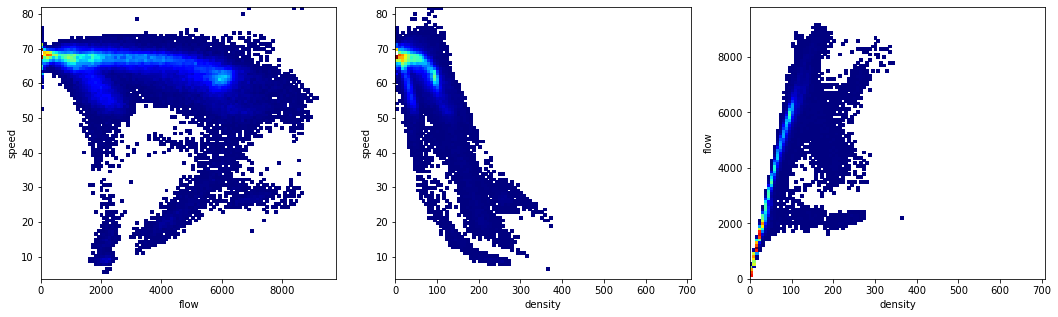

In [139]:
flow_heatmap(sf_counts, col_flow ='flow', col_speed= 'Avg Speed', col_density = 'density')

In [138]:
def flow_heatmap(df, col_flow, col_speed, col_density):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
    ax1.hist2d(df[col_flow], df[col_speed], (100, 100), cmin=5, cmax=2000, cmap=plt.cm.jet)
    ax1.set_xlabel('flow')
    ax1.set_ylabel('speed')

    ax2.hist2d(df[col_density], df[col_speed], (100, 100), cmin=5, cmax=3000, cmap=plt.cm.jet)
    ax2.set_xlabel('density')
    ax2.set_ylabel('speed')

    ax3.hist2d(df[col_density], df[col_flow], (100, 100), cmin=5, cmax=8000, cmap=plt.cm.jet)
    ax3.set_xlabel('density')
    ax3.set_ylabel('flow')
    plt.show()

## Per lane 

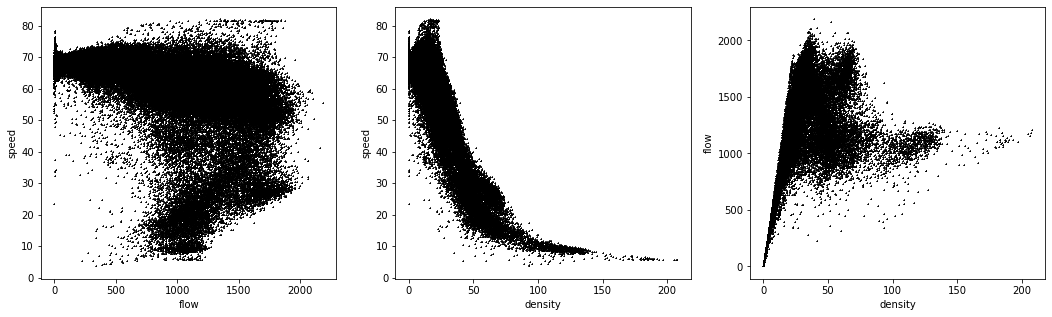

In [135]:
flow_scatter(sf_counts, col_flow ='lane_flow', col_speed= 'Avg Speed', col_density = 'lane_dens')

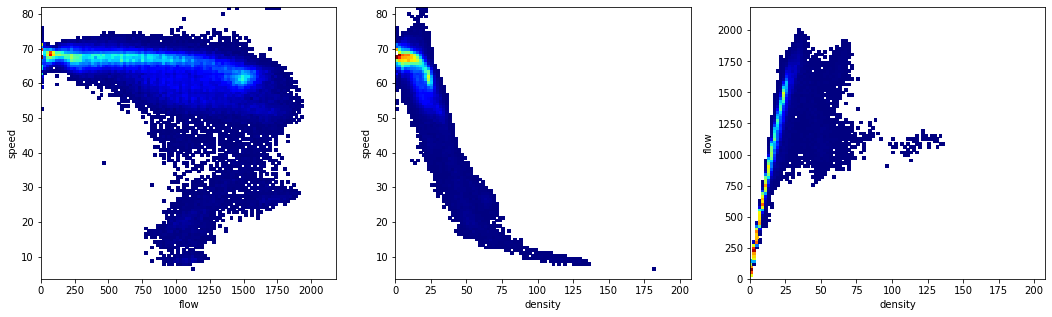

In [137]:
df, col_flow, col_speed, col_density = sf_counts, 'lane_flow', 'Avg Speed', 'lane_dens'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
ax1.hist2d(df[col_flow], df[col_speed], (100, 100), cmin=5, cmax=1800, cmap=plt.cm.jet)
ax1.set_xlabel('flow')
ax1.set_ylabel('speed')

ax2.hist2d(df[col_density], df[col_speed], (100, 100), cmin=5, cmax=3000, cmap=plt.cm.jet)
ax2.set_xlabel('density')
ax2.set_ylabel('speed')

ax3.hist2d(df[col_density], df[col_flow], (100, 100), cmin=5, cmax=6000, cmap=plt.cm.jet)
ax3.set_xlabel('density')
ax3.set_ylabel('flow')
plt.show()